# NETFLIX STOCK PRICE PREDICTION

In [96]:
!pip install pmdarima
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [97]:
!pip install prophet
!pip install pandas-profiling

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [98]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf

from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## Data Preprocessing

### Read dataset

In [99]:
netflix = pd.read_csv('nflx.csv')

In [100]:
netflix.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2025-02-25,989.40,994.40,955.00,977.24,977.24,4733000
1,2025-02-24,1008.00,1015.17,984.48,988.47,988.47,4426200
2,2025-02-21,1029.42,1032.38,999.39,1003.15,1003.15,3738700
3,2025-02-20,1042.00,1045.00,1015.59,1024.54,1024.54,3111800
4,2025-02-19,1035.18,1045.00,1024.51,1043.33,1043.33,2600000


In [101]:
netflix = netflix.iloc[::-1]

In [102]:
netflix.head()

,Date,Open,High,Low,Close,Adj Close,Volume
5726,2002-05-23,1.16,1.24,1.15,1.20,1.20,104790000
5725,2002-05-24,1.21,1.23,1.20,1.21,1.21,11104800
5724,2002-05-28,1.21,1.23,1.16,1.16,1.16,6609400
5723,2002-05-29,1.16,1.16,1.09,1.10,1.10,6757800
5722,2002-05-30,1.11,1.11,1.07,1.07,1.07,10154200


### Sanity check

In [103]:
netflix.shape

(5727, 7)

In [104]:
netflix.info() #shows that there is no missing value since all columns are complete (non-null)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5727 entries, 5726 to 0
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5727 non-null   object 
 1   Open       5727 non-null   float64
 2   High       5727 non-null   float64
 3   Low        5727 non-null   float64
 4   Close      5727 non-null   float64
 5   Adj Close  5727 non-null   float64
 6   Volume     5727 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 313.3+ KB


In [105]:
netflix.isnull().sum() #finding missing values

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [106]:
netflix.duplicated().sum() #finding number of duplicates

0

In [107]:
netflix['Date'] = pd.to_datetime(netflix.Date,format='%Y-%m-%d')

netflix.set_index('Date', inplace=True)            # Set it as the index


## Exploratory Data Analysis

In [108]:
netflix.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,5727.0,1.612611e+02,2.131627e+02,0.38,4.265,44.97,3.087700e+02,1.060000e+03
High,5727.0,1.636277e+02,2.159504e+02,0.41,4.355,45.93,3.134900e+02,1.064500e+03
Low,5727.0,1.588396e+02,2.102681e+02,0.35,4.190,43.93,3.031850e+02,1.041690e+03
Close,5727.0,1.612933e+02,2.131595e+02,0.37,4.260,44.86,3.093150e+02,1.058600e+03
Adj Close,5727.0,1.612933e+02,2.131595e+02,0.37,4.260,44.86,3.093150e+02,1.058600e+03
Volume,5727.0,1.529105e+07,1.845139e+07,285600.00,5460550.000,9531100.00,1.820050e+07,3.234140e+08


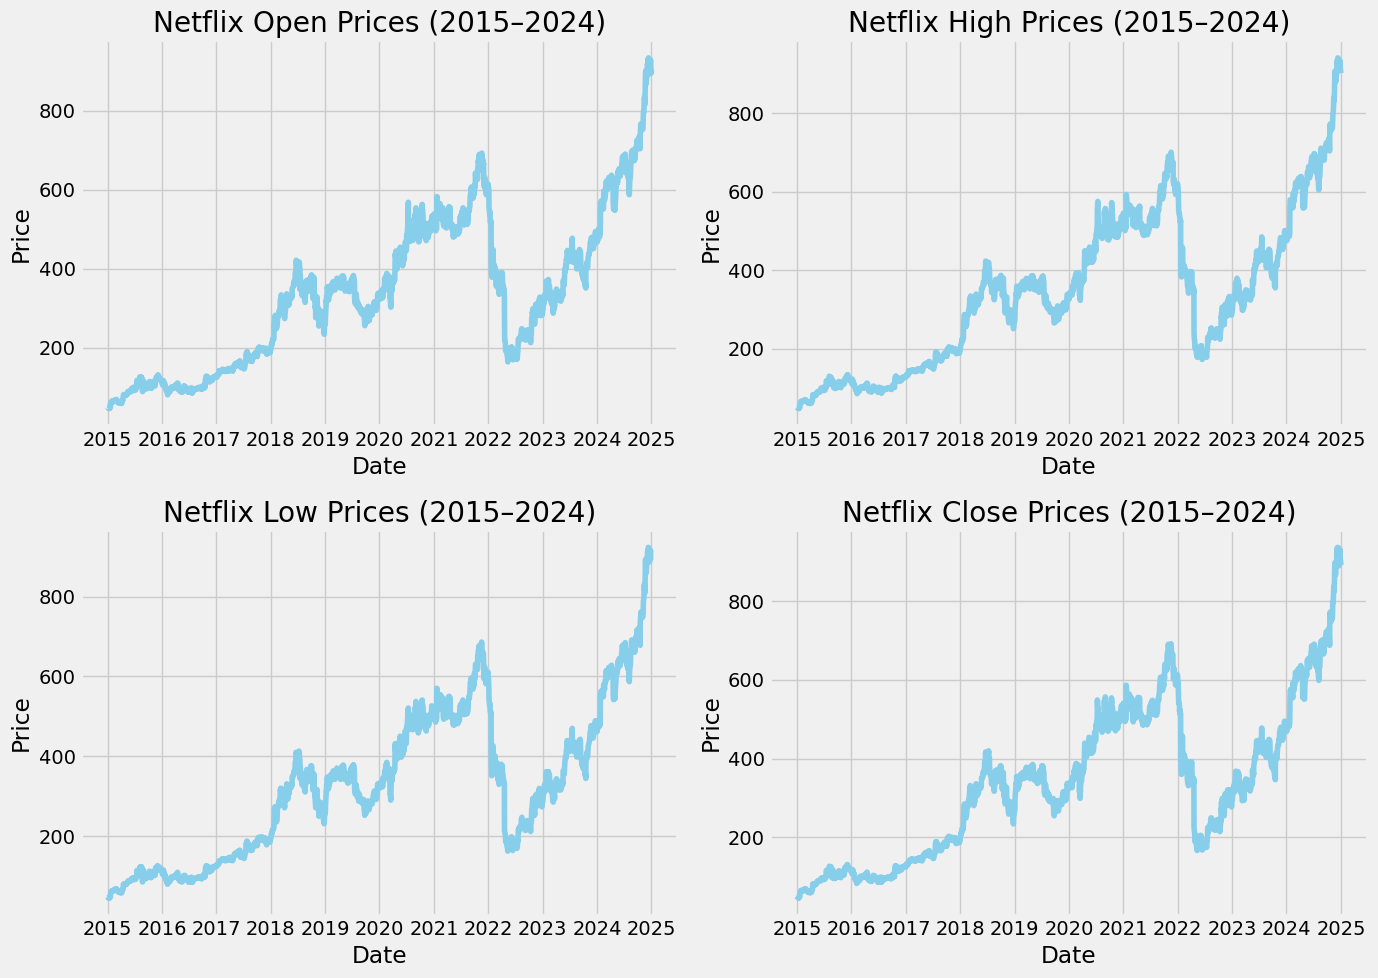

In [347]:
import matplotlib.pyplot as plt

# Filter data from 2015 to 2024
netflix_filtered = netflix['2015':'2024']

# Define the columns you want to plot
price_columns = ['Open', 'High', 'Low', 'Close']

# Set up subplots
plt.figure(figsize=(14, 10))

for i, column in enumerate(price_columns):
    plt.subplot(2, 2, i + 1)  # 2x2 grid of plots
    plt.plot(netflix_filtered.index, netflix_filtered[column], label=column, color='skyblue')
    plt.title(f'Netflix {column} Prices (2015–2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.tight_layout()

# Save and show
plt.savefig('netflix_separate_prices_plots.png')
plt.show()


<Figure size 1200x800 with 0 Axes>

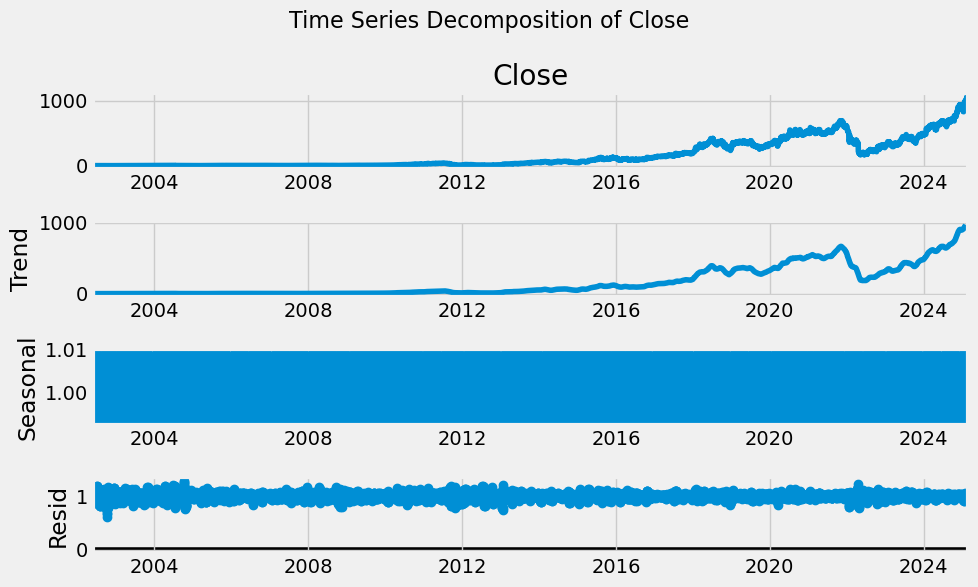

In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Make sure 'Date' is the index and in datetime format
df_decompose = netflix[['Close']].copy()


# Set datetime index if not already
df_decompose.index = pd.to_datetime(df_decompose.index)

# Decompose the log-transformed time series (assume daily frequency)
result = seasonal_decompose(df_decompose['Close'], model='multiplicative', period=30)  # period=30 assumes ~monthly seasonality

# Plot the decomposition
plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('Time Series Decomposition of Close', fontsize=16)
plt.tight_layout()
plt.show()


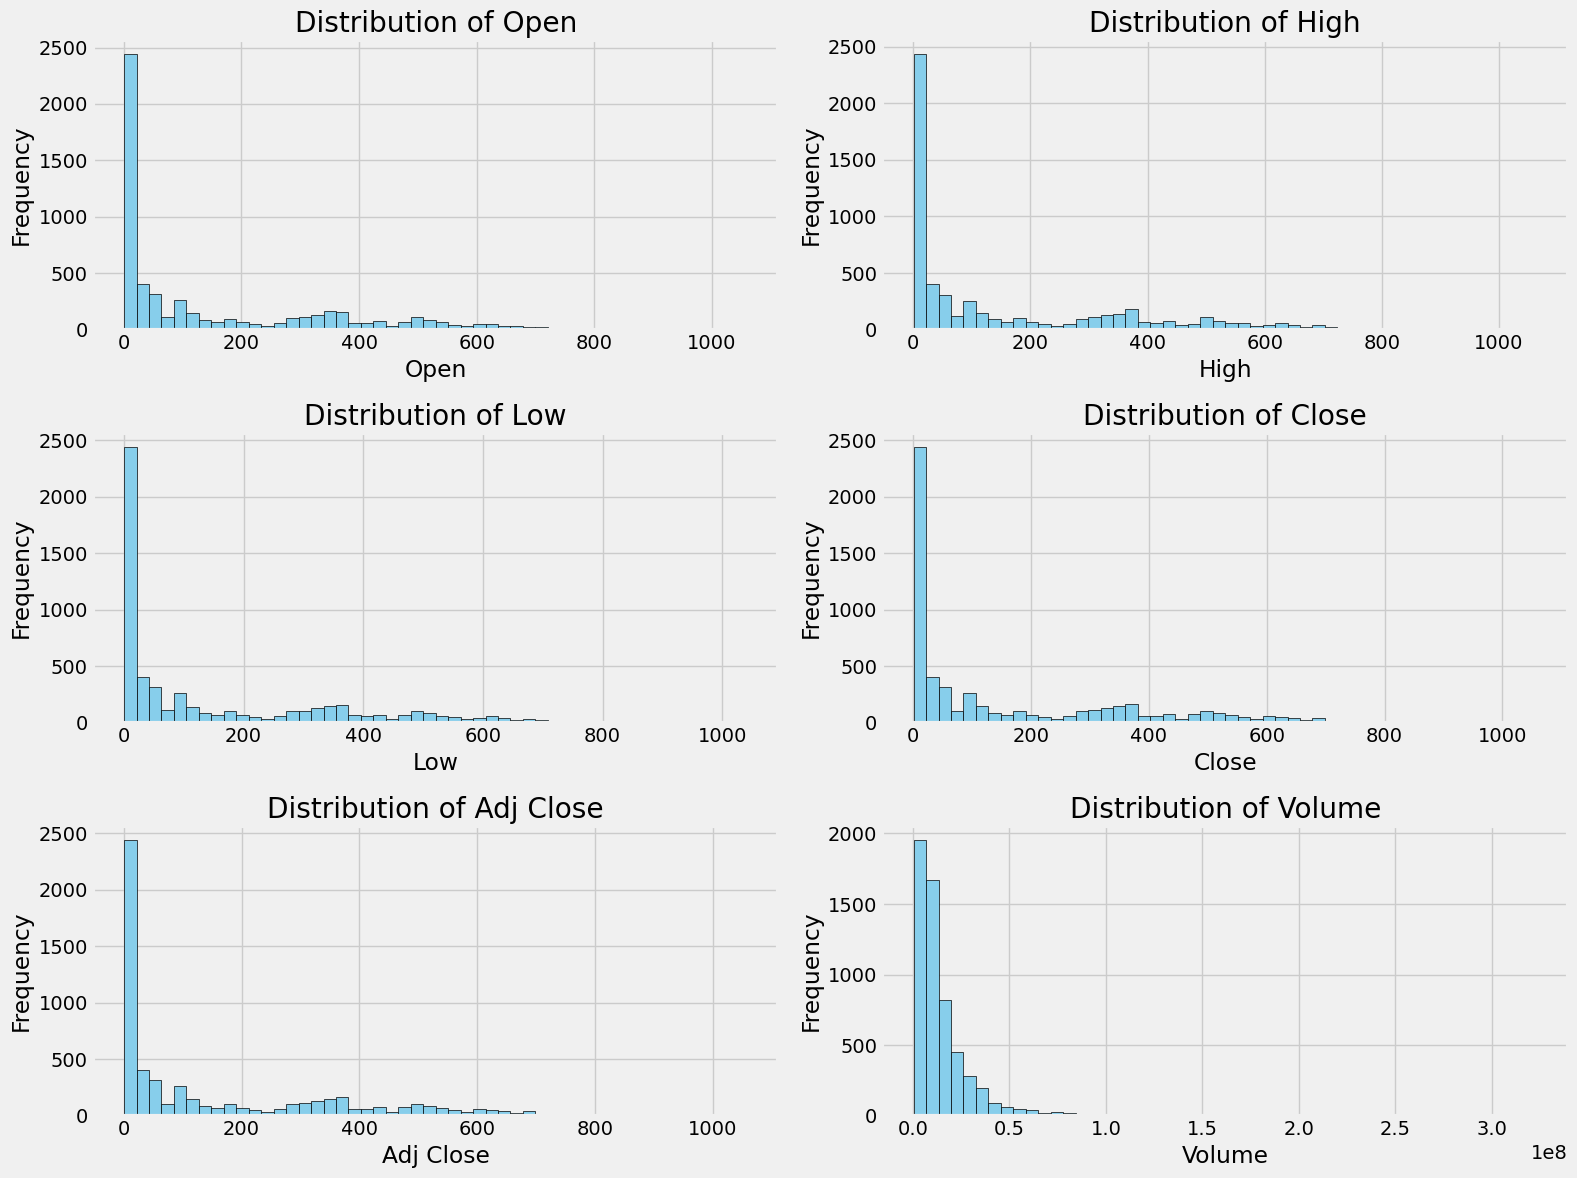

In [110]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'netflix' is your DataFrame
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

plt.figure(figsize=(16, 12))
for i, col in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    plt.hist(netflix[col].dropna(), bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

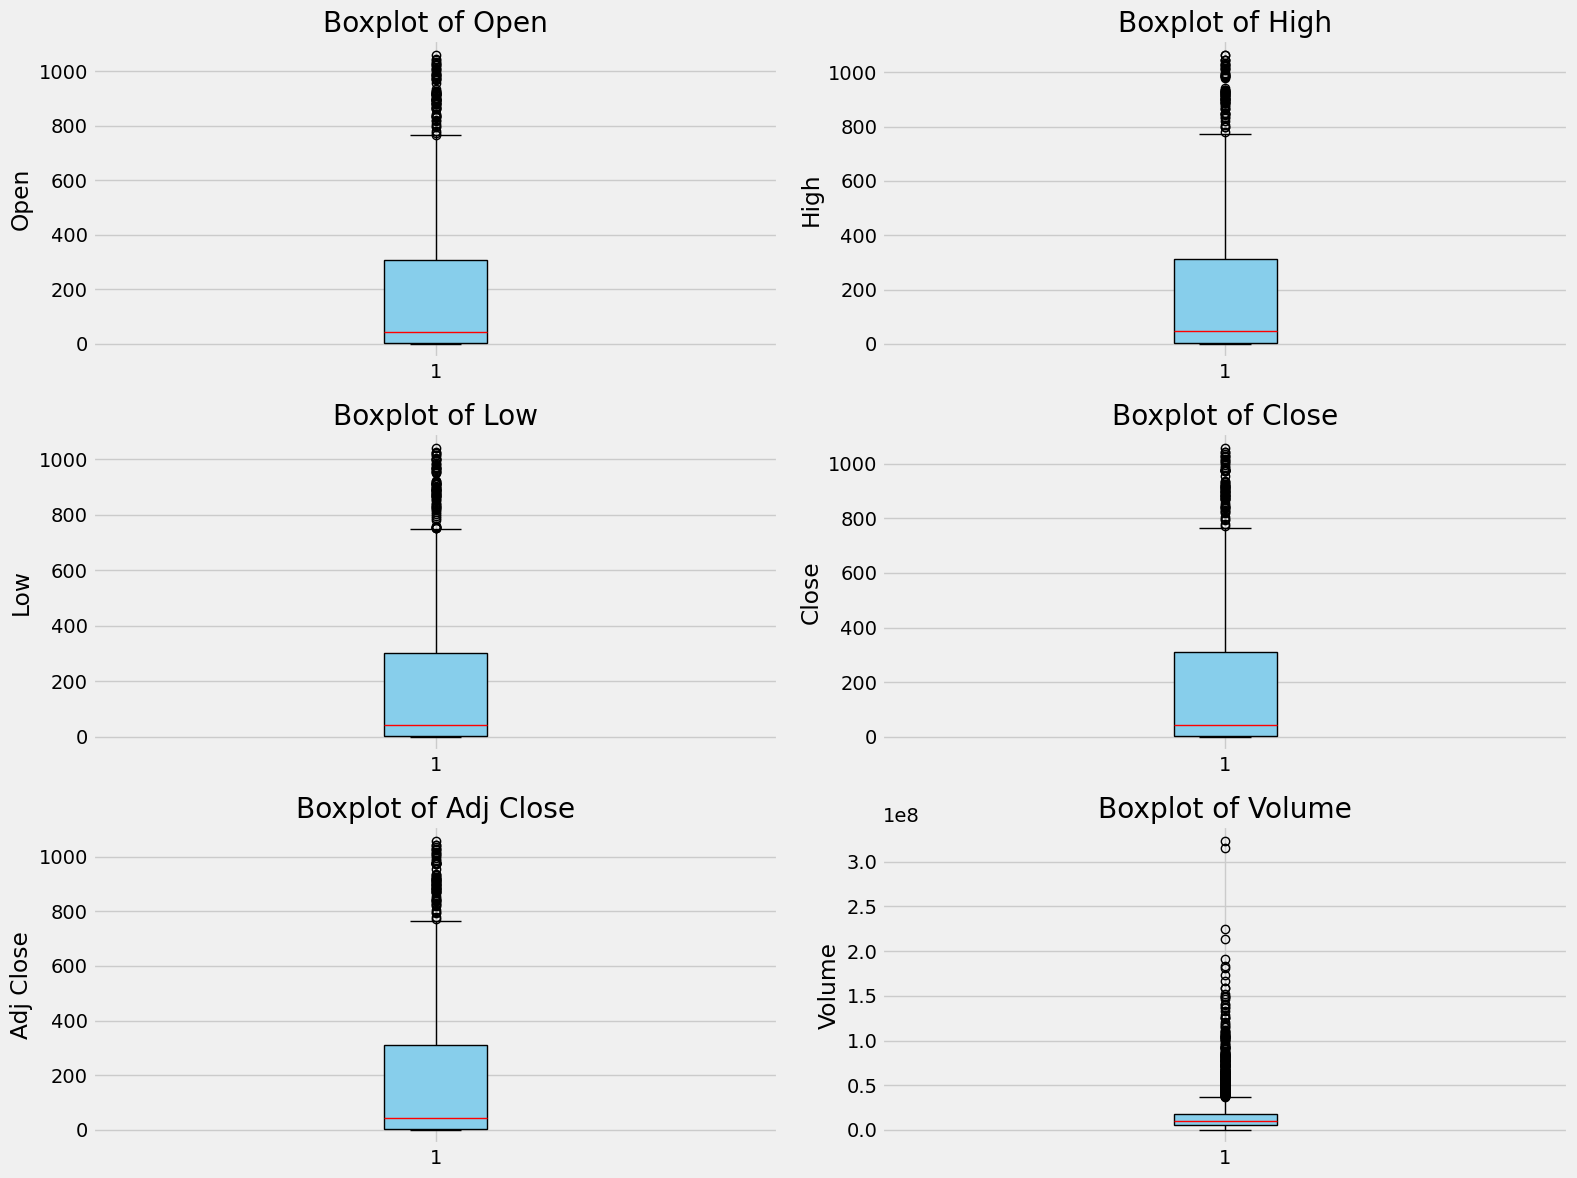

In [111]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'netflix' is your DataFrame
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

plt.figure(figsize=(16, 12))
for i, col in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    plt.boxplot(netflix[col].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='black'),
                medianprops=dict(color='red'))
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


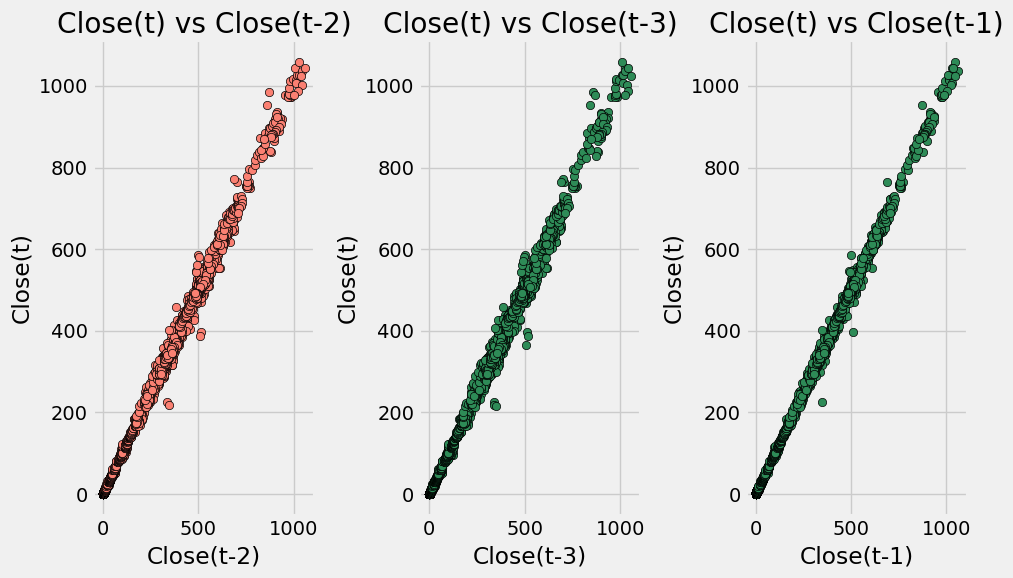

In [112]:
import matplotlib.pyplot as plt

# Assuming 'netflix' is your DataFrame with a 'Close' column
# suggests that the current value is dependent on the past values
# Create lagged Close Price (Close(t-1))
netflix['Close_Lag1'] = netflix['Close'].shift(1)  
netflix['Close_Lag2'] = netflix['Close'].shift(2)
netflix['Close_Lag3'] = netflix['Close'].shift(3)

# Drop NaN values (due to shifting)
netflix = netflix.dropna()

# Plot Close vs Lagged Close (Close(t) vs Close(t-1))
plt.subplot(1, 3, 1)
plt.scatter(netflix['Close_Lag2'], netflix['Close'], color='salmon', edgecolor='black')
plt.title("Close(t) vs Close(t-2)")
plt.xlabel("Close(t-2)")
plt.ylabel("Close(t)")
plt.grid(True)

# Close(t) vs Close(t-3)
plt.subplot(1, 3, 2)
plt.scatter(netflix['Close_Lag3'], netflix['Close'], color='seagreen', edgecolor='black')
plt.title("Close(t) vs Close(t-3)")
plt.xlabel("Close(t-3)")
plt.ylabel("Close(t)")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(netflix['Close_Lag1'], netflix['Close'], color='seagreen', edgecolor='black')
plt.title("Close(t) vs Close(t-1)")
plt.xlabel("Close(t-1)")
plt.ylabel("Close(t)")
plt.grid(True)

plt.tight_layout()
plt.show()



### Handling the outliers

In [372]:


"""def remove_outliers_iqr(df, cols):
    mask = pd.Series(True, index=df.index)
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask &= df[col].between(lower, upper)
    return df[mask].copy() """
def cap_outliers_iqr(df, columns):
    capped_df = df.copy()
    for col in columns:
        q1 = capped_df[col].quantile(0.25)
        q3 = capped_df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # Cap the outliers
        capped_df[col] = capped_df[col].clip(lower=lower_bound, upper=upper_bound)
    return capped_df

# Apply it to your data
netflix_iqr_cleaned = cap_outliers_iqr(netflix, ['Open', 'Close'])



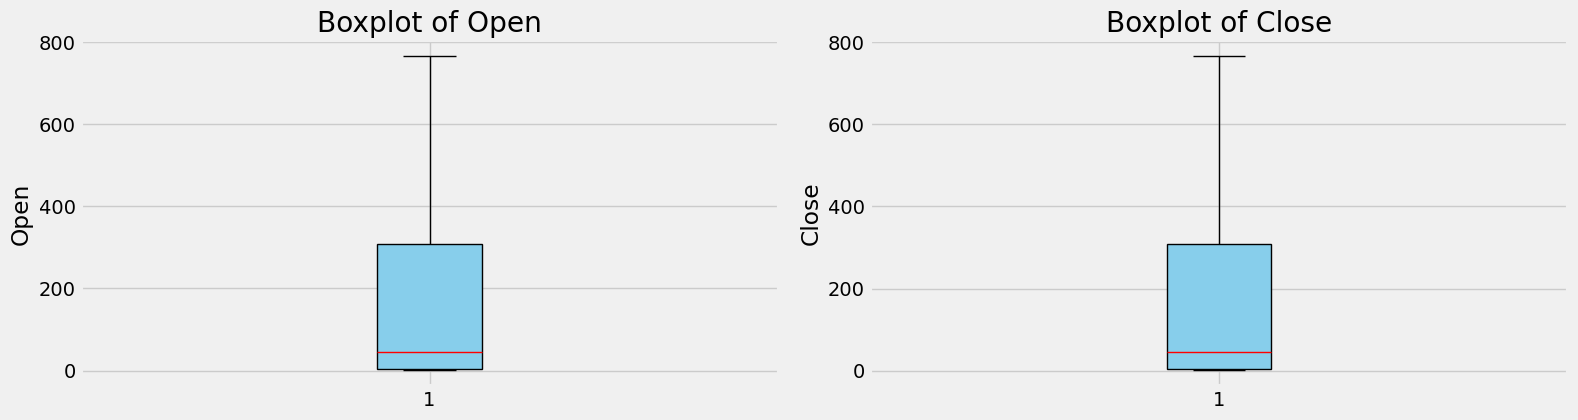

In [373]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'netflix_iqr_cleaned' is your cleaned DataFrame
cols = ['Open', 'Close']

plt.figure(figsize=(16, 12))
for i, col in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    plt.boxplot(netflix_iqr_cleaned[col].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='black'),
                medianprops=dict(color='red'))
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


## Stationarity

In [374]:
# Define a function which will give us rolling mean and standard deviation and perform ADF Test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [385]:
netflix_iqr_cleaned = netflix_iqr_cleaned.iloc[::-1]

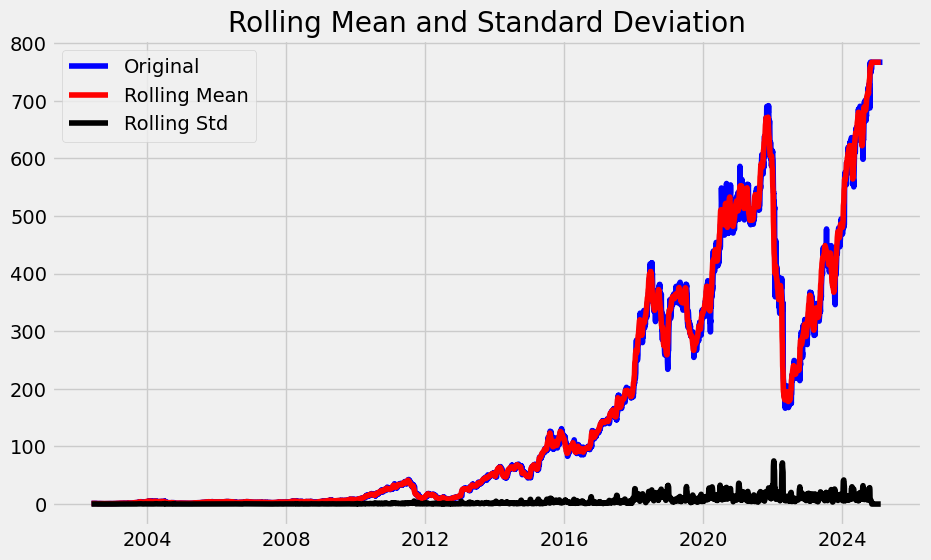

Results of dickey fuller test
Test Statistics                  -2.996721
p-value                           0.035202
No. of lags used                 33.000000
Number of observations used    5690.000000
critical value (1%)              -3.431500
critical value (5%)              -2.862048
critical value (10%)             -2.567040
dtype: float64


In [376]:
test_stationarity(netflix_iqr_cleaned['Close'])

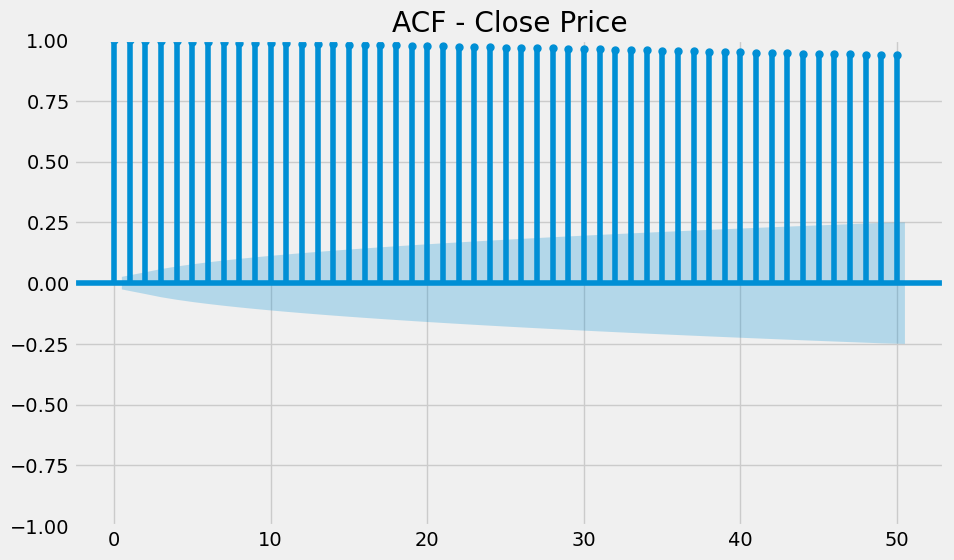

In [377]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(netflix_iqr_cleaned['Close'].dropna(), lags=50)
plt.title("ACF - Close Price")
plt.show()


### Transform to stationary (Log differencing)

In [378]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def transform_and_test_stationarity(timeseries):
    # Transformation to make the data stationary
    timeseries_log = np.log(timeseries)
    timeseries_log_diff = timeseries_log.diff().dropna()

    # Plot rolling statistics
    rolmean = timeseries_log_diff.rolling(window=12).mean()
    rolstd = timeseries_log_diff.rolling(window=12).std()

    plt.figure(figsize=(6, 4))
    plt.plot(timeseries_log_diff, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Log-Difference')
    plt.show()

    # Perform ADF test
    adft = adfuller(timeseries_log_diff, autolag='AIC')

    # Output the ADF test results
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)
    
    # Return the transformed series (log difference)
    return timeseries_log_diff


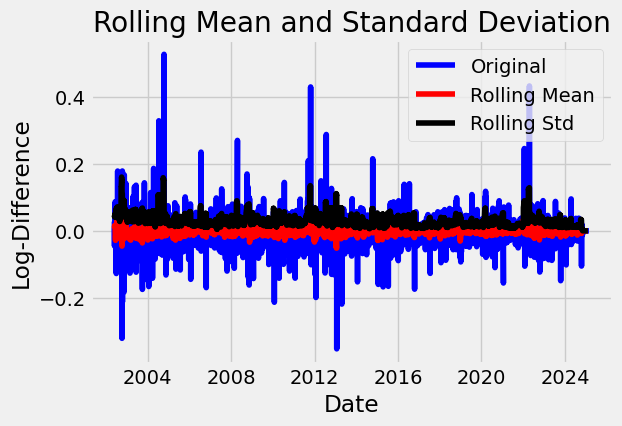

Test Statistic                  -73.896856
p-value                           0.000000
Number of Lags Used               0.000000
Number of Observations Used    5722.000000
Critical Value (1%)              -3.431493
Critical Value (5%)              -2.862045
Critical Value (10%)             -2.567039
dtype: float64


In [379]:
netflix_transformed=transform_and_test_stationarity(netflix_iqr_cleaned['Close'])

In [380]:
netflix_transformed = netflix_transformed.iloc[::-1]

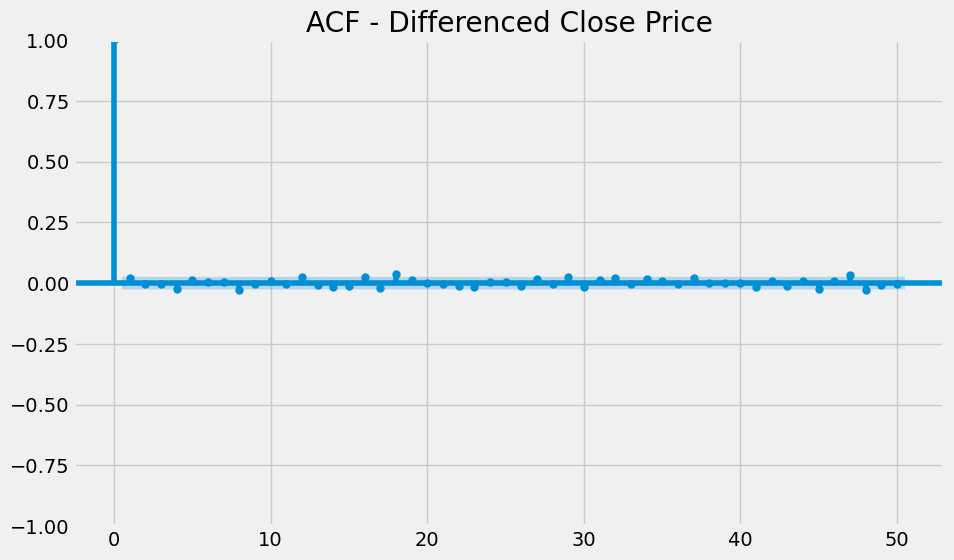

In [381]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF of the transformed log-differenced series
plot_acf(netflix_transformed, lags=50)
plt.title("ACF - Differenced Close Price")
plt.show()


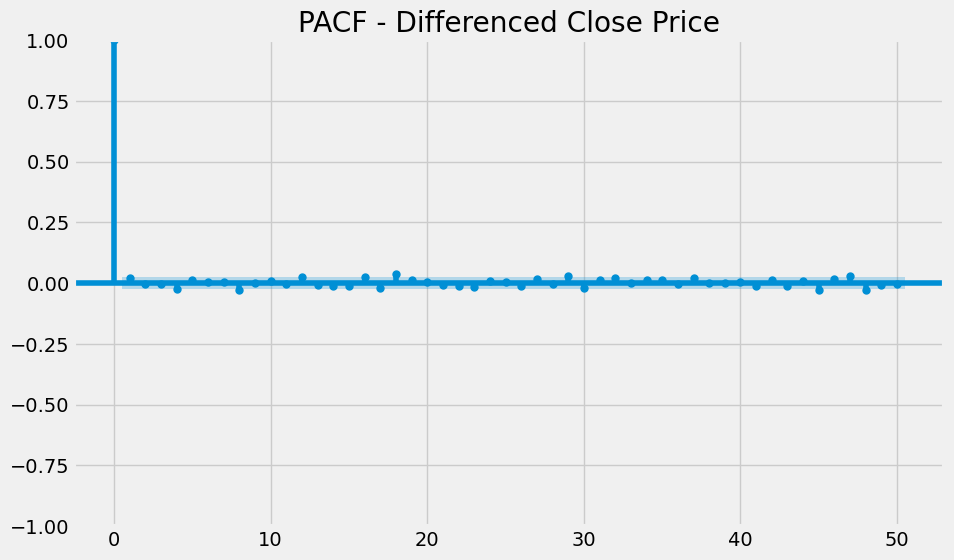

In [382]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot ACF of the transformed log-differenced series
plot_pacf(netflix_transformed, lags=50)
plt.title("PACF - Differenced Close Price")
plt.show()


## Model selection

In [386]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt

def moving_avg_prediction(netflix_iqr_cleaned):
    shape = netflix_iqr_cleaned.shape[0]
    df_new = netflix_iqr_cleaned[['Close']].copy()
    df_new['Close_log'] = np.log(df_new['Close'])

    # Step 2: First-order differencing
    df_new['Close_log_diff'] = df_new['Close_log'].diff()
    df_new = df_new.dropna()
    train_set = df_new.iloc[:ceil(shape * 0.9)]
    valid_set = df_new.iloc[ceil(shape * 0.9):]

    print('-----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)

    preds_diff = []
    for i in range(0, valid_set.shape[0]):
        a = train_set['Close_log_diff'][len(train_set) - valid_set.shape[0] + i:].sum() + sum(preds_diff)
        b = a / (valid_set.shape[0])
        preds_diff.append(b)

    # Back-transform: reconstruct log prices
    last_log_price = df_new['Close_log'].iloc[train_set.shape[0] - 1]
    preds_log = [last_log_price + preds_diff[0]]
    for i in range(1, len(preds_diff)):
        preds_log.append(preds_log[i - 1] + preds_diff[i])

    # Convert back to original scale
    preds = np.exp(preds_log)

    rms = np.sqrt(np.mean(np.power((np.array(valid_set['Close']) - preds), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid_set['Predictions'] = preds

    plt.figure(figsize=(6, 4))
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date', size=20)
    plt.ylabel('Log-transformed Close Price', size=20)
    plt.title('Close Price Prediction by Moving Averages', size=20)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])


-----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set: (5152, 3)
Shape of Validation Set: (571, 3)
RMSE value on validation set: 383.1357955188648
-----------------------------------------------------------
-----------------------------------------------------------


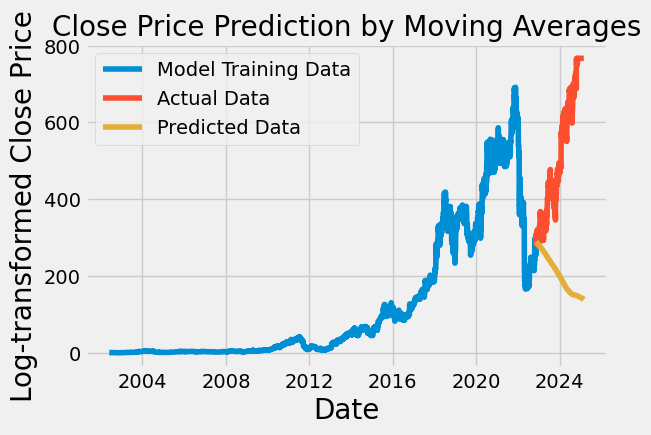

In [387]:
moving_avg_prediction(netflix_iqr_cleaned)

In [350]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

def ar1_prediction(netflix_iqr_cleaned):
    shape = netflix_iqr_cleaned.shape[0]
    df_new = netflix_iqr_cleaned[['Close']].copy()

    # Step 1: Log transformation
    df_new['Close_log'] = np.log(df_new['Close'])

    # Step 2: First-order differencing
    df_new['Close_log_diff'] = df_new['Close_log'].diff()
    df_new = df_new.dropna()  # Drop NA values created by differencing
    train_set = df_new.iloc[:ceil(shape * 0.9)]
    valid_set = df_new.iloc[ceil(shape * 0.9):]

    print('-----------------------------------------------------------')
    print('---------- STOCK PRICE PREDICTION USING AR(1) -------------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)

    # Fit AR(1) model on the differenced log data
    model_ar1 = AutoReg(train_set['Close_log_diff'], lags=1)
    model_ar1_fitted = model_ar1.fit()

    # Predict the log-differenced values (log scale)
    ar1_preds_diff = model_ar1_fitted.predict(
        start=len(train_set),
        end=len(train_set) + len(valid_set) - 1
    )

    # Back-transform: reconstruct log prices
    last_log_price = df_new['Close_log'].iloc[train_set.shape[0] - 1]  # last log value in the training set
    ar1_preds_log = [last_log_price + ar1_preds_diff.iloc[0]]  # First prediction, using .iloc to access by position
    for i in range(1, len(ar1_preds_diff)):
        ar1_preds_log.append(ar1_preds_log[i - 1] + ar1_preds_diff.iloc[i])  # Cumulative sum of predictions

    # Convert back to original scale
    ar1_preds = np.exp(ar1_preds_log)

    # Calculate RMSE
    ar1_rmse = np.sqrt(mean_squared_error(valid_set['Close'], ar1_preds))
    print(f'RMSE for AR(1): {ar1_rmse:.6f}')
    print('-----------------------------------------------------------')

    valid_set['Predictions'] = ar1_preds

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(train_set['Close'], label='Training')
    plt.plot(valid_set['Close'], label='Validation')
    plt.plot(valid_set['Predictions'], label='AR(1) Predictions', linestyle='--')
    plt.xlabel('Date', size=12)
    plt.ylabel('Close Price', size=12)
    plt.title('Close Price Prediction Using AR(1)', size=14)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [351]:
ar1_prediction(netflix_iqr_cleaned)

-----------------------------------------------------------
---------- STOCK PRICE PREDICTION USING AR(1) -------------
-----------------------------------------------------------
Shape of Training Set: (5084, 2)
Shape of Validation Set: (564, 2)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [326]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def sarima_prediction(netflix):
    shape = netflix.shape[0]
    df_new = netflix[['Close']].copy()

    # Step 1: Log transformation
    df_new['Close_log'] = np.log(df_new['Close'])

    # Step 2: First-order differencing
    df_new['Close_log_diff'] = df_new['Close_log'].diff()
    df_new = df_new.dropna()
    
    # Train-test split
    train_size = ceil(len(df_new) * 0.9)
    train = df_new.iloc[:train_size]
    test = df_new.iloc[train_size:]

    # Fit SARIMA model
    model = SARIMAX(train['Close_log'],
                    order=(1, 1, 1),                # ARIMA order (p, d, q)
                    seasonal_order=(1, 1, 1, 7),    # Seasonal order (P, D, Q, s) — weekly seasonality assumed
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    sarima_result = model.fit(disp=False)

    # Forecasting
    forecast = sarima_result.get_forecast(steps=len(test))
    predicted_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Back-transform the predictions (original scale)
    predicted_mean_original = np.exp(predicted_mean)  # Exponentiate to get back to the original scale
    lower_bound_original = np.exp(conf_int.iloc[:, 0])  # Lower bound of confidence interval
    upper_bound_original = np.exp(conf_int.iloc[:, 1])  # Upper bound of confidence interval

    # RMSE calculation
    rmse = np.sqrt(mean_squared_error(test['Close'], predicted_mean_original))
    print(f"SARIMA RMSE on validation set (original scale): {rmse:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train['Close'], label='Train')
    plt.plot(test.index, test['Close'], label='Test')
    plt.plot(test.index, predicted_mean_original, label='Forecast', color='red')
    plt.fill_between(test.index, lower_bound_original, upper_bound_original, color='pink', alpha=0.3)
    plt.title("SARIMA Forecast (Back-transformed)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


SARIMA RMSE on validation set (original scale): 173.4730


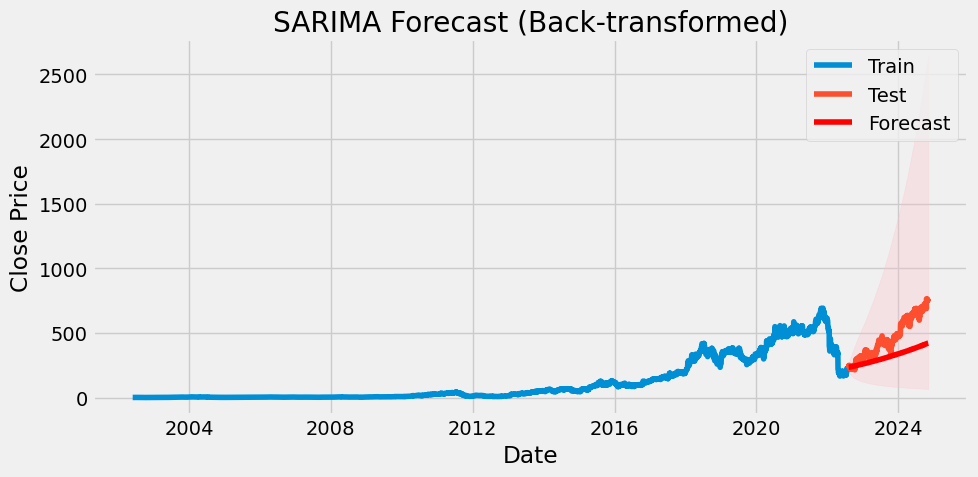

In [327]:
sarima_prediction(netflix_iqr_cleaned)

In [388]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from math import ceil
import matplotlib.pyplot as plt

def arima_prediction(netflix_iqr_cleaned):
    shape = netflix_iqr_cleaned.shape[0]
    df_arima = netflix_iqr_cleaned[['Close']].copy()

    # Step 1: Log transformation (no manual differencing)
    df_arima['Close_log'] = np.log(df_arima['Close'])

    # Train-test split on log-transformed series
    train_size = ceil(len(df_arima) * 0.9)
    train = df_arima['Close_log'].iloc[:train_size]
    test = df_arima['Close_log'].iloc[train_size:]

    best_aic = float('inf')
    best_model = None
    best_order = None

    # Loop over different ARIMA(p,1,q) configurations
    for p in range(0, 2):  # try p = 1 to 5
        for q in range(0, 2):  # try q = 1 to 5
            try:
                model = ARIMA(train, order=(p, 1, q))  # d=1 to let ARIMA handle differencing
                arima_result = model.fit()

                print(f"ARIMA(p={p}, d=1, q={q}) AIC: {arima_result.aic:.2f}")

                if arima_result.aic < best_aic:
                    best_aic = arima_result.aic
                    best_model = arima_result
                    best_order = (p, 1, q)

            except Exception as e:
                print(f"Failed to fit ARIMA(p={p}, d=1, q={q}): {e}")
                continue

    print(f"\nBest ARIMA Model: ARIMA{best_order}")
    print(f"Best AIC: {best_aic:.2f}")

    # Final Forecast using best model
    forecast = best_model.get_forecast(steps=len(test))
    predicted_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    predicted_mean_original = np.exp(predicted_mean)
    lower_bound_original = np.exp(conf_int.iloc[:, 0])
    upper_bound_original = np.exp(conf_int.iloc[:, 1])
    actual = np.exp(test)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, np.exp(train), label='Train')
    plt.plot(test.index, actual, label='Test')
    plt.plot(test.index, predicted_mean_original, label='Forecast', color='red')
    plt.fill_between(test.index, lower_bound_original, upper_bound_original, color='pink', alpha=0.3)
    plt.title(f"ARIMA{best_order} Forecast on Netflix Close Prices (AIC-based selection)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


ARIMA(p=0, d=1, q=0) AIC: -19500.18
ARIMA(p=0, d=1, q=1) AIC: -19500.81
ARIMA(p=1, d=1, q=0) AIC: -19500.81
ARIMA(p=1, d=1, q=1) AIC: -19498.81

Best ARIMA Model: ARIMA(0, 1, 1)
Best AIC: -19500.81


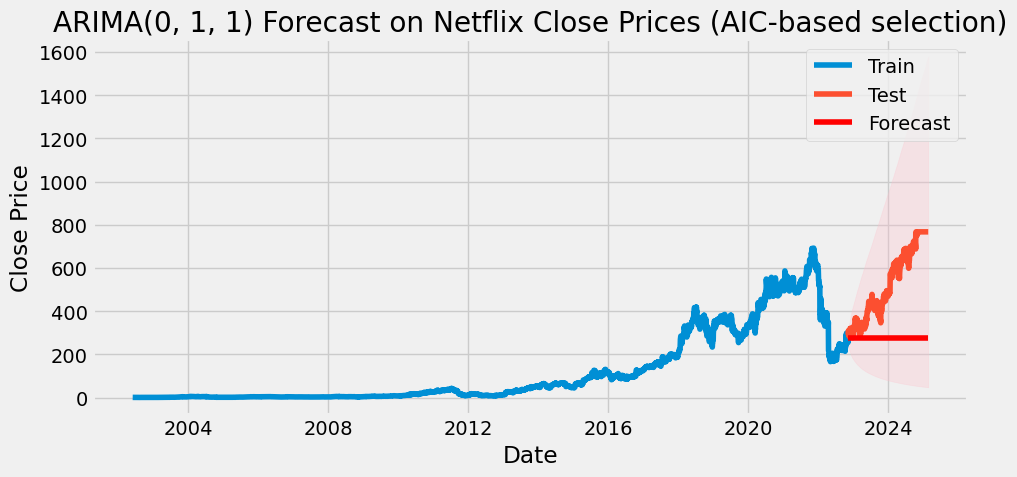

In [389]:
arima_prediction(netflix_iqr_cleaned)


In [343]:
from pmdarima import auto_arima
shape = netflix.shape[0]
df_arima = netflix[['Close']].copy()

# Step 1: Log transformation
df_arima['Close_log'] = np.log(df_arima['Close'])

    # Step 2: First-order differencing
df_arima['Close_log_diff'] = df_arima['Close_log'].diff()
df_arima = df_arima.dropna()
auto_model = auto_arima(df_arima['Close_log_diff'],
                        start_p=0, start_q=0,
                        max_p=20, max_q=20,
                        d=1,           # since you've differenced
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18216.321, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19758.444, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18218.321, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-20406.666, Time=0.52 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-20716.434, Time=0.60 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-20988.616, Time=0.68 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-21156.148, Time=1.14 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-21280.873, Time=1.09 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-21335.103, Time=1.29 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=-21411.861, Time=2.06 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=-21480.496, Time=2.84 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=-21523.257, Time=2.68 sec
 ARIMA(11,1,0)(0,0,0)[0] intercept   : AIC=-21588.106, Time=14.38 sec
 ARIMA(12

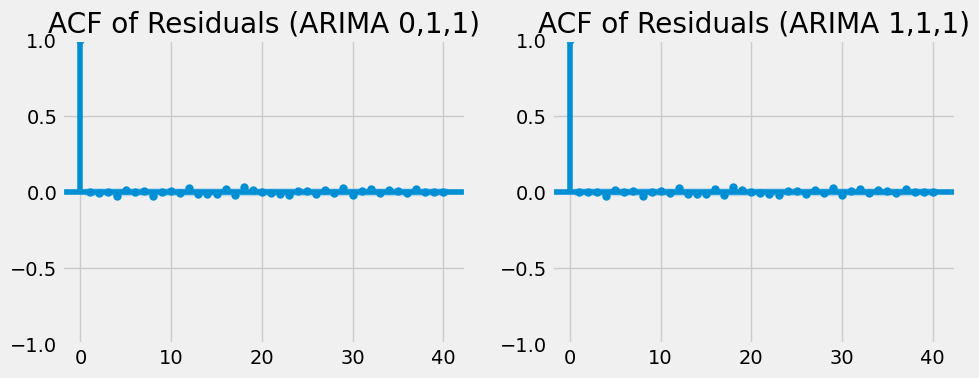

Ljung-Box Test Results for ARIMA(0,1,1):
    lb_pvalue
1    0.917588
2    0.972957
3    0.995705
4    0.443813
5    0.476713
6    0.596886
7    0.683983
8    0.334724
9    0.428186
10   0.494861
11   0.571106
12   0.362684
13   0.409131
14   0.402489
15   0.425715
16   0.278659
17   0.218653
18   0.050132
19   0.054900
20   0.073209
21   0.093686
22   0.101404
23   0.099362
24   0.115940
25   0.140899
26   0.144858
27   0.138640
28   0.166541
29   0.096125
30   0.087681
31   0.095679
32   0.073182
33   0.089365
34   0.088714
35   0.100914
36   0.120667
37   0.087441
38   0.106376
39   0.127988
40   0.151863

Ljung-Box Test Results for ARIMA(1,1,1):
    lb_pvalue
1    0.917542
2    0.990142
3    0.998518
4    0.449096
5    0.481370
6    0.601944
7    0.688460
8    0.338226
9    0.432025
10   0.498762
11   0.574919
12   0.365860
13   0.412167
14   0.406312
15   0.429024
16   0.280641
17   0.220320
18   0.050383
19   0.055242
20   0.073620
21   0.094171
22   0.101949
23   0.099896
24   0.

In [390]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming netflix_iqr_cleaned is your dataset
df_arima = netflix_iqr_cleaned[['Close']].copy()

# Step 1: Log transformation (no manual differencing)
df_arima['Close_log'] = np.log(df_arima['Close'])

# Fit ARIMA(0, 1, 1)
model_011 = ARIMA(df_arima['Close_log'], order=(0, 1, 1))
fitted_model_011 = model_011.fit()
residuals_011 = fitted_model_011.resid

# Fit ARIMA(1, 1, 1)
model_111 = ARIMA(df_arima['Close_log'], order=(1, 1, 1))
fitted_model_111 = model_111.fit()
residuals_111 = fitted_model_111.resid

# Plot ACF of residuals for ARIMA(0,1,1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_acf(residuals_011, lags=40, ax=plt.gca())
plt.title("ACF of Residuals (ARIMA 0,1,1)")

# Plot ACF of residuals for ARIMA(1,1,1)
plt.subplot(1, 2, 2)
plot_acf(residuals_111, lags=40, ax=plt.gca())
plt.title("ACF of Residuals (ARIMA 1,1,1)")

plt.tight_layout()
plt.show()

# Perform Ljung-Box test on the residuals for both models
lb_test_011 = acorr_ljungbox(residuals_011, lags=40, return_df=True)
lb_test_111 = acorr_ljungbox(residuals_111, lags=40, return_df=True)

# Print the p-values of the Ljung-Box test for both models
print("Ljung-Box Test Results for ARIMA(0,1,1):")
print(lb_test_011[['lb_pvalue']])

print("\nLjung-Box Test Results for ARIMA(1,1,1):")
print(lb_test_111[['lb_pvalue']])

# Forecasting for RMSE calculation
forecast_011 = fitted_model_011.forecast(steps=len(df_arima))
forecast_111 = fitted_model_111.forecast(steps=len(df_arima))

# Calculate RMSE for ARIMA(0,1,1)
rmse_011 = np.sqrt(mean_squared_error(df_arima['Close_log'], forecast_011))

# Calculate RMSE for ARIMA(1,1,1)
rmse_111 = np.sqrt(mean_squared_error(df_arima['Close_log'], forecast_111))

# Print the RMSE values
print(f"\nRMSE for ARIMA(0,1,1): {rmse_011}")
print(f"RMSE for ARIMA(1,1,1): {rmse_111}")

# Interpretation:
# RMSE is a measure of the average error magnitude of the model's predictions.
# Lower RMSE indicates a better fit to the data.
